This notebook is part of Laurence Moroney's Time Series Prediction using Tensorflow

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from matplotlib import pyplot as plt
import matplotlib.image  as mpimg

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [3]:
#df = pd.read_csv('../input/sunspots/Sunspots.csv', squeeze=True, index_col=1)
df = pd.read_csv('../input/sunspots/Sunspots.csv')
print(df.columns)
print(df.info())
print(df.head(10))

Index(['Unnamed: 0', 'Date', 'Monthly Mean Total Sunspot Number'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252 entries, 0 to 3251
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3252 non-null   int64  
 1   Date                               3252 non-null   object 
 2   Monthly Mean Total Sunspot Number  3252 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.3+ KB
None
   Unnamed: 0        Date  Monthly Mean Total Sunspot Number
0           0  1749-01-31                               96.7
1           1  1749-02-28                              104.3
2           2  1749-03-31                              116.7
3           3  1749-04-30                               92.8
4           4  1749-05-31                              141.7
5           5  1749-06-30                              13

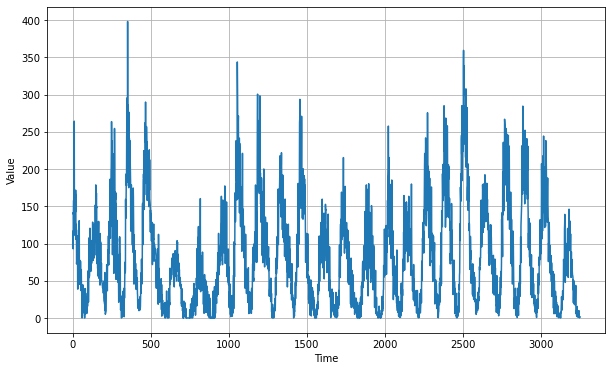

In [4]:
series = np.array(df.iloc[:,2])
time = np.array(df.iloc[:,0])

plt.figure(figsize=(10,6))
plot_series(time, series)

In [5]:
split_time=3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


In [6]:
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
12/12 [==============================] - 2s 172ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 2s 168ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 2s 168ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 2s 174ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 2s 170ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 2s 170ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 2s 170ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 2s 174ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 2s 172ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/12 [==============================] - 2s 181ms/step - loss: 52.3436 - mae: 52.8400
Epoch 11/100
12/12 

12/12 [==============================] - 2s 168ms/step - loss: 45.3478 - mae: 45.8446
Epoch 84/100
12/12 [==============================] - 2s 168ms/step - loss: 56.1352 - mae: 56.6333
Epoch 85/100
12/12 [==============================] - 2s 164ms/step - loss: 56.8706 - mae: 57.3689
Epoch 86/100
12/12 [==============================] - 2s 167ms/step - loss: 56.0533 - mae: 56.5517
Epoch 87/100
12/12 [==============================] - 2s 167ms/step - loss: 54.2815 - mae: 54.7797
Epoch 88/100
12/12 [==============================] - 2s 206ms/step - loss: 54.5301 - mae: 55.0283
Epoch 89/100
12/12 [==============================] - 2s 184ms/step - loss: 53.7172 - mae: 54.2152
Epoch 90/100
12/12 [==============================] - 2s 170ms/step - loss: 53.1182 - mae: 53.6163
Epoch 91/100
12/12 [==============================] - 2s 170ms/step - loss: 52.4815 - mae: 52.9795
Epoch 92/100
12/12 [==============================] - 2s 173ms/step - loss: 53.9424 - mae: 54.4408
Epoch 93/100
12/12 [===

(1e-08, 0.0001, 0.0, 60.0)

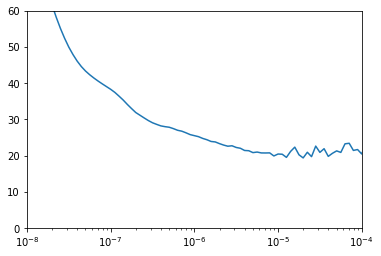

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 2s 83ms/step - loss: 38.9180 - mae: 39.4144
Epoch 2/500
30/30 [==============================] - 2s 82ms/step - loss: 25.7650 - mae: 26.2595
Epoch 3/500
30/30 [==============================] - 2s 82ms/step - loss: 22.0822 - mae: 22.5759
Epoch 4/500
30/30 [==============================] - 3s 85ms/step - loss: 20.4544 - mae: 20.9474
Epoch 5/500
30/30 [==============================] - 2s 82ms/step - loss: 19.3239 - mae: 19.8159
Epoch 6/500
30/30 [==============================] - 2s 82ms/step - loss: 19.0463 - mae: 19.5383
Epoch 7/500
30/30 [==============================] - 2s 83ms/step - loss: 18.4912 - mae: 18.9830
Epoch 8/500
30/30 [==============================] - 3s 84ms/step - loss: 18.3489 - mae: 18.8405
Epoch 9/500
30/30 [==============================] - 3s 87ms/step - loss: 18.2389 - mae: 18.7306
Epoch 10/500
30/30 [==============================] - 3s 91ms/step - loss: 20.0183 - mae: 20.5105
Epoch 11/500
30/30 [=========

30/30 [==============================] - 3s 84ms/step - loss: 16.3807 - mae: 16.8688
Epoch 85/500
30/30 [==============================] - 3s 84ms/step - loss: 16.4690 - mae: 16.9578
Epoch 86/500
30/30 [==============================] - 3s 83ms/step - loss: 16.7146 - mae: 17.2034
Epoch 87/500
30/30 [==============================] - 2s 83ms/step - loss: 16.6386 - mae: 17.1277
Epoch 88/500
30/30 [==============================] - 2s 83ms/step - loss: 16.3756 - mae: 16.8646
Epoch 89/500
30/30 [==============================] - 3s 84ms/step - loss: 16.3720 - mae: 16.8606
Epoch 90/500
30/30 [==============================] - 3s 89ms/step - loss: 16.3444 - mae: 16.8328
Epoch 91/500
30/30 [==============================] - 3s 85ms/step - loss: 16.4248 - mae: 16.9137
Epoch 92/500
30/30 [==============================] - 3s 84ms/step - loss: 16.4084 - mae: 16.8969
Epoch 93/500
30/30 [==============================] - 3s 86ms/step - loss: 16.4847 - mae: 16.9737
Epoch 94/500
30/30 [=============

30/30 [==============================] - 2s 83ms/step - loss: 15.8931 - mae: 16.3816
Epoch 168/500
30/30 [==============================] - 3s 86ms/step - loss: 16.0264 - mae: 16.5151
Epoch 169/500
30/30 [==============================] - 3s 90ms/step - loss: 15.8445 - mae: 16.3326
Epoch 170/500
30/30 [==============================] - 2s 83ms/step - loss: 15.9107 - mae: 16.3989
Epoch 171/500
30/30 [==============================] - 3s 86ms/step - loss: 15.8397 - mae: 16.3276
Epoch 172/500
30/30 [==============================] - 3s 94ms/step - loss: 15.8760 - mae: 16.3642
Epoch 173/500
30/30 [==============================] - 3s 92ms/step - loss: 15.8921 - mae: 16.3805
Epoch 174/500
30/30 [==============================] - 3s 95ms/step - loss: 15.9900 - mae: 16.4784
Epoch 175/500
30/30 [==============================] - 3s 85ms/step - loss: 15.9236 - mae: 16.4118
Epoch 176/500
30/30 [==============================] - 2s 83ms/step - loss: 15.8352 - mae: 16.3232
Epoch 177/500
30/30 [===

30/30 [==============================] - 3s 83ms/step - loss: 15.5764 - mae: 16.0639
Epoch 250/500
30/30 [==============================] - 2s 83ms/step - loss: 15.4714 - mae: 15.9587
Epoch 251/500
30/30 [==============================] - 2s 82ms/step - loss: 15.4871 - mae: 15.9743
Epoch 252/500
30/30 [==============================] - 2s 82ms/step - loss: 15.5269 - mae: 16.0140
Epoch 253/500
30/30 [==============================] - 2s 81ms/step - loss: 15.4483 - mae: 15.9356
Epoch 254/500
30/30 [==============================] - 2s 82ms/step - loss: 15.5037 - mae: 15.9910
Epoch 255/500
30/30 [==============================] - 2s 81ms/step - loss: 15.4992 - mae: 15.9863
Epoch 256/500
30/30 [==============================] - 2s 82ms/step - loss: 15.5182 - mae: 16.0058
Epoch 257/500
30/30 [==============================] - 2s 82ms/step - loss: 15.4709 - mae: 15.9580
Epoch 258/500
30/30 [==============================] - 2s 82ms/step - loss: 15.4434 - mae: 15.9304
Epoch 259/500
30/30 [===

30/30 [==============================] - 3s 90ms/step - loss: 15.2638 - mae: 15.7502
Epoch 332/500
30/30 [==============================] - 3s 85ms/step - loss: 15.7552 - mae: 16.2431
Epoch 333/500
30/30 [==============================] - 3s 84ms/step - loss: 15.1796 - mae: 15.6659
Epoch 334/500
30/30 [==============================] - 3s 84ms/step - loss: 15.1751 - mae: 15.6615
Epoch 335/500
30/30 [==============================] - 2s 82ms/step - loss: 15.1432 - mae: 15.6290
Epoch 336/500
30/30 [==============================] - 2s 83ms/step - loss: 15.1119 - mae: 15.5979
Epoch 337/500
30/30 [==============================] - 2s 83ms/step - loss: 15.0910 - mae: 15.5770
Epoch 338/500
30/30 [==============================] - 3s 84ms/step - loss: 15.1858 - mae: 15.6719
Epoch 339/500
30/30 [==============================] - 2s 82ms/step - loss: 15.1596 - mae: 15.6457
Epoch 340/500
30/30 [==============================] - 3s 87ms/step - loss: 15.0765 - mae: 15.5625
Epoch 341/500
30/30 [===

30/30 [==============================] - 2s 83ms/step - loss: 14.7833 - mae: 15.2687
Epoch 414/500
30/30 [==============================] - 2s 82ms/step - loss: 14.8549 - mae: 15.3408
Epoch 415/500
30/30 [==============================] - 3s 90ms/step - loss: 14.9412 - mae: 15.4275
Epoch 416/500
30/30 [==============================] - 3s 86ms/step - loss: 15.1895 - mae: 15.6767
Epoch 417/500
30/30 [==============================] - 3s 91ms/step - loss: 14.8532 - mae: 15.3397
Epoch 418/500
30/30 [==============================] - 3s 86ms/step - loss: 14.7489 - mae: 15.2341
Epoch 419/500
30/30 [==============================] - 3s 85ms/step - loss: 14.8101 - mae: 15.2963
Epoch 420/500
30/30 [==============================] - 3s 83ms/step - loss: 14.8775 - mae: 15.3637
Epoch 421/500
30/30 [==============================] - 3s 84ms/step - loss: 14.9675 - mae: 15.4540
Epoch 422/500
30/30 [==============================] - 3s 85ms/step - loss: 14.9171 - mae: 15.4033
Epoch 423/500
30/30 [===

30/30 [==============================] - 3s 87ms/step - loss: 14.5496 - mae: 15.0349
Epoch 496/500
30/30 [==============================] - 2s 82ms/step - loss: 14.5464 - mae: 15.0318
Epoch 497/500
30/30 [==============================] - 2s 83ms/step - loss: 14.5839 - mae: 15.0695
Epoch 498/500
30/30 [==============================] - 2s 83ms/step - loss: 14.6240 - mae: 15.1097
Epoch 499/500
30/30 [==============================] - 2s 83ms/step - loss: 14.5251 - mae: 15.0105
Epoch 500/500
30/30 [==============================] - 3s 89ms/step - loss: 14.7841 - mae: 15.2708


In [10]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

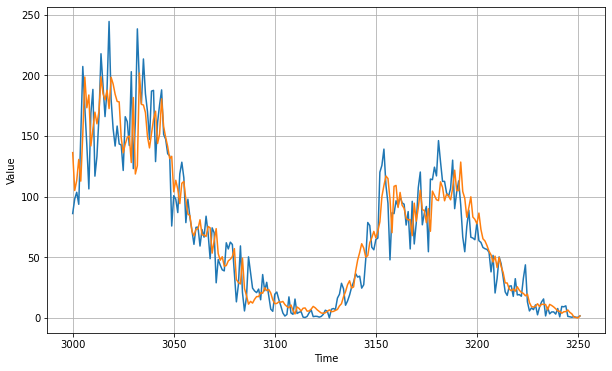

In [11]:
plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.390822

<Figure size 432x288 with 0 Axes>

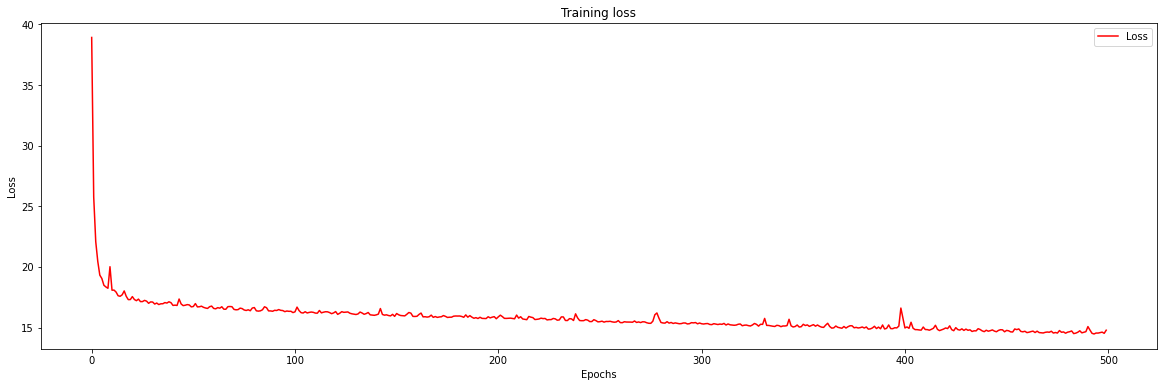

<Figure size 432x288 with 0 Axes>

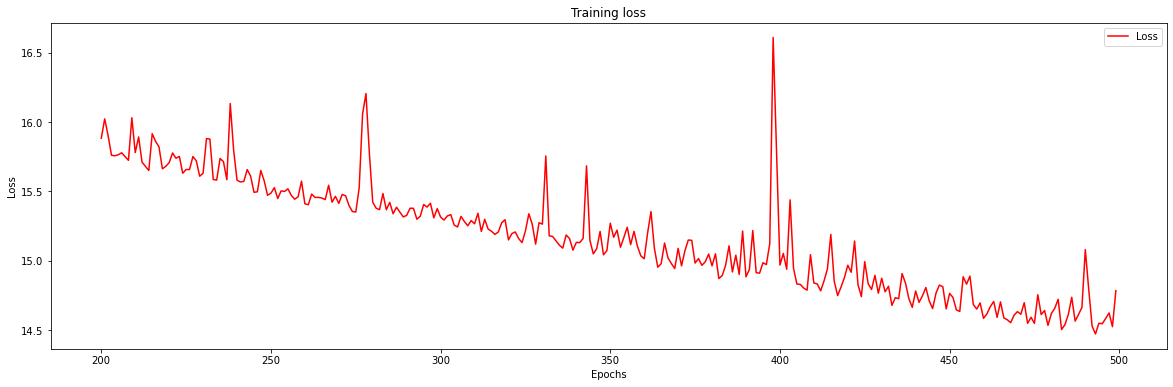

<Figure size 432x288 with 0 Axes>

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(20, 6))
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(20,6))
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [14]:
print(rnn_forecast)

[ 1.36192261e+02  1.04965271e+02  1.13321075e+02  1.30592697e+02
  1.12688805e+02  1.51527374e+02  1.98526871e+02  1.73177673e+02
  1.83706604e+02  1.41716995e+02  1.55437073e+02  1.69544189e+02
  1.59939117e+02  1.70088379e+02  1.98756409e+02  1.84875717e+02
  1.79759583e+02  1.87646179e+02  1.72476135e+02  1.98341446e+02
  1.92845871e+02  1.84364288e+02  1.78417450e+02  1.78020248e+02
  1.48545715e+02  1.36082947e+02  1.43206390e+02  1.48717453e+02
  1.49906952e+02  1.28050446e+02  1.81578796e+02  1.18581947e+02
  1.25477364e+02  2.01856018e+02  1.75963898e+02  1.75461441e+02
  1.69174820e+02  1.49505707e+02  1.40072983e+02  1.51571945e+02
  1.63657684e+02  1.70343872e+02  1.43729675e+02  1.51501572e+02
  1.80513687e+02  1.57692947e+02  1.48791351e+02  1.41213440e+02
  1.31241852e+02  1.33146042e+02  1.03881691e+02  1.13391449e+02
  1.06083679e+02  9.41825256e+01  1.10934082e+02  1.12426758e+02
  9.73536224e+01  8.55397339e+01  8.43246078e+01  7.15097122e+01
  6.77318268e+01  7.29731